<a href="https://colab.research.google.com/github/thisaraniNJ/Aircraft_Damage_Prediction/blob/main/Aircraft_Damage_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Necessary Libraries

In [1]:
!pip install statsmodels

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None) # To represent all the columns in the dataset
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from imblearn.under_sampling import RandomUnderSampler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, f1_score

# Loading Data

In [3]:
Aviation = pd.read_csv('/content/drive/MyDrive/My ML Projects/AviationData.csv', encoding='mac_roman')

In [4]:
Aviation.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,Aircraft.Category,Registration.Number,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,FAR.Description,Schedule,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,Fatal(2),Destroyed,NaN,NC6404,Stinson,108-3,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,Fatal(4),Destroyed,NaN,N5069P,Piper,PA24-180,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,Fatal(3),Destroyed,NaN,N5142R,Cessna,172M,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,Fatal(2),Destroyed,NaN,N1168J,Rockwell,112,No,1.0,Reciprocating,NaN,NaN,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,Fatal(1),Destroyed,NaN,N15NY,Cessna,501,No,NaN,NaN,NaN,NaN,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [5]:
Aviation.shape

(87282, 31)

There are 87282 flights have been captured to make a prediction

# Data Description

Non-Null Values, Datatypes, % of null values

In [6]:
info_dict = {
    "Column": Aviation.columns.tolist(),
    "Non-Null Count" : Aviation.count(),
    "Dtypes": Aviation.dtypes.tolist(),
    "Null Precentage":(Aviation.shape[0]-Aviation.count())/Aviation.shape[0]*100
}

Description = pd.DataFrame(info_dict).reset_index(drop=True)


In [7]:
Description

,Column,Non-Null Count,Dtypes,Null Precentage
0,Event.Id,87282,object,0.000000
1,Investigation.Type,87282,object,0.000000
2,Accident.Number,87282,object,0.000000
3,Event.Date,87282,object,0.000000
4,Location,87230,object,0.059577
5,Country,87056,object,0.258931
6,Latitude,33073,object,62.107880
7,Longitude,33064,object,62.118192
8,Airport.Code,49217,object,43.611512
9,Airport.Name,51870,object,40.571939


Statistical Summary

In [8]:
Aviation.describe()

,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
count,81533.000000,75881.000000,74772.000000,75349.000000,81370.000000
mean,1.147131,0.652772,0.280921,0.360814,5.311847
std,0.447085,5.521338,1.557476,2.257721,27.899156
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000
max,8.000000,349.000000,161.000000,380.000000,699.000000


In [9]:
Aviation.describe(include='object', exclude='number')

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,Aircraft.Category,Registration.Number,Make,Model,Amateur.Built,Engine.Type,FAR.Description,Schedule,Purpose.of.flight,Air.carrier,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
count,87282,87282,87282,87282,87230,87056,33073,33064,49217,51870,86399,84272,30783,85900,87219,87190,87180,81372,30458,12330,81493,15971,83304,61724,82067,73629
unique,86370,2,87282,14435,27171,210,24752,26206,10252,24545,107,4,12,77696,8045,12185,4,10,31,3,28,13079,4,12,16666,2686
top,20001212X19172,Accident,GAA22WA047,2000-07-08,"ANCHORAGE, AK",United States,332739N,0112457W,NONE,Private,Non-Fatal,Substantial,Airplane,NONE,Cessna,152,No,Reciprocating,091,NSCH,Personal,Pilot,VMC,Landing,Probable Cause,25-09-2020
freq,3,83536,1,25,434,80998,19,22,1486,232,66561,62975,26343,344,22227,2350,58165,69159,17131,4284,48655,246,76251,15428,61754,17019


# Exploratory Data Analysis (EDA)

Data Cleaning

In [10]:
# Check for duplicates
Aviation[Aviation.duplicated()]

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,Aircraft.Category,Registration.Number,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,FAR.Description,Schedule,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date


In [11]:
# Check for missing values
miss_values=Aviation.isnull().sum()
miss_values[miss_values>0]

,0
Location,52
Country,226
Latitude,54209
Longitude,54218
Airport.Code,38065
Airport.Name,35412
Injury.Severity,883
Aircraft.damage,3010
Aircraft.Category,56499
Registration.Number,1382


In [12]:
miss_values[miss_values>0].index

Index(['Location', 'Country', 'Latitude', 'Longitude', 'Airport.Code',
       'Airport.Name', 'Injury.Severity', 'Aircraft.damage',
       'Aircraft.Category', 'Registration.Number', 'Make', 'Model',
       'Amateur.Built', 'Number.of.Engines', 'Engine.Type', 'FAR.Description',
       'Schedule', 'Purpose.of.flight', 'Air.carrier', 'Total.Fatal.Injuries',
       'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured',
       'Weather.Condition', 'Broad.phase.of.flight', 'Report.Status',
       'Publication.Date'],
      dtype='object')

In [13]:
Null_values = pd.DataFrame() # Create an empty Dataframe to store columns and their null values

Null_values['Columns'] = miss_values[miss_values>0].index.tolist()
Null_values['Null_values']=miss_values[miss_values>0].values.tolist()

# Displaying the percentage of null values for each column and add them to the Null_vlaues dataframe
pct_null_values = list((Aviation.isnull().sum() [Aviation.isnull().sum()>0].values/Aviation.shape[0]*100).round(2))
Null_values['%_null_values']= [str(i)+ '%' for i in pct_null_values]

In [14]:
Null_values

,Columns,Null_values,%_null_values
0,Location,52,0.06%
1,Country,226,0.26%
2,Latitude,54209,62.11%
3,Longitude,54218,62.12%
4,Airport.Code,38065,43.61%
5,Airport.Name,35412,40.57%
6,Injury.Severity,883,1.01%
7,Aircraft.damage,3010,3.45%
8,Aircraft.Category,56499,64.73%
9,Registration.Number,1382,1.58%


In [15]:
pct_null_values

[np.float64(0.06),
 np.float64(0.26),
 np.float64(62.11),
 np.float64(62.12),
 np.float64(43.61),
 np.float64(40.57),
 np.float64(1.01),
 np.float64(3.45),
 np.float64(64.73),
 np.float64(1.58),
 np.float64(0.07),
 np.float64(0.11),
 np.float64(0.12),
 np.float64(6.59),
 np.float64(6.77),
 np.float64(65.1),
 np.float64(85.87),
 np.float64(6.63),
 np.float64(81.7),
 np.float64(13.06),
 np.float64(14.33),
 np.float64(13.67),
 np.float64(6.77),
 np.float64(4.56),
 np.float64(29.28),
 np.float64(5.97),
 np.float64(15.64)]

Categorical Data

In [16]:
# Using simple Imputer to fill in the null space with the mode values for categorical data
from sklearn.impute import SimpleImputer
Imputer = SimpleImputer(strategy='most_frequent')
Imputer.fit(Aviation.select_dtypes('object'))


SimpleImputer(strategy='most_frequent')

In [17]:
DF = pd.DataFrame(Imputer.transform(Aviation.select_dtypes('object')), columns=Aviation.select_dtypes('object').columns)

In [18]:
DF.isnull().sum()

,0
Event.Id,0
Investigation.Type,0
Accident.Number,0
Event.Date,0
Location,0
Country,0
Latitude,0
Longitude,0
Airport.Code,0
Airport.Name,0


In [19]:
Aviation['Number.of.Engines'].unique()

array([ 1., nan,  2.,  0.,  3.,  4.,  8.])

In [20]:
# reating the number of engines with mode

Aviation['Number.of.Engines'].fillna(Aviation['Number.of.Engines'].mode()[0],inplace=True)

Numerical Data

In [21]:
Aviation.select_dtypes('number').isnull().sum()

,0
Number.of.Engines,0
Total.Fatal.Injuries,11401
Total.Serious.Injuries,12510
Total.Minor.Injuries,11933
Total.Uninjured,5912


In [22]:
Imputer_n = SimpleImputer(strategy='mean')
Imputer_n.fit(Aviation.select_dtypes(np.number))
DF_1 = pd.DataFrame(Imputer_n.transform(Aviation.select_dtypes(np.number)), columns=Aviation.select_dtypes(np.number).columns)

In [23]:
DF_1.isnull().sum()

,0
Number.of.Engines,0
Total.Fatal.Injuries,0
Total.Serious.Injuries,0
Total.Minor.Injuries,0
Total.Uninjured,0


In [24]:
# Concatinating the DF and DF_1

Aviation = pd.concat([DF, DF_1], axis=1)

Aviation

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,Aircraft.Category,Registration.Number,Make,Model,Amateur.Built,Engine.Type,FAR.Description,Schedule,Purpose.of.flight,Air.carrier,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,332739N,0112457W,NONE,Private,Fatal(2),Destroyed,Airplane,NC6404,Stinson,108-3,No,Reciprocating,091,NSCH,Personal,Pilot,UNK,Cruise,Probable Cause,25-09-2020,1.0,2.0,0.000000,0.000000,0.000000
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,332739N,0112457W,NONE,Private,Fatal(4),Destroyed,Airplane,N5069P,Piper,PA24-180,No,Reciprocating,091,NSCH,Personal,Pilot,UNK,Unknown,Probable Cause,19-09-1996,1.0,4.0,0.000000,0.000000,0.000000
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NONE,Private,Fatal(3),Destroyed,Airplane,N5142R,Cessna,172M,No,Reciprocating,091,NSCH,Personal,Pilot,IMC,Cruise,Probable Cause,26-02-2007,1.0,3.0,0.280921,0.360814,5.311847
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,332739N,0112457W,NONE,Private,Fatal(2),Destroyed,Airplane,N1168J,Rockwell,112,No,Reciprocating,091,NSCH,Personal,Pilot,IMC,Cruise,Probable Cause,12-09-2000,1.0,2.0,0.000000,0.000000,0.000000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,332739N,0112457W,NONE,Private,Fatal(1),Destroyed,Airplane,N15NY,Cessna,501,No,Reciprocating,091,NSCH,Personal,Pilot,VMC,Approach,Probable Cause,16-04-1980,1.0,1.0,2.000000,0.360814,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87277,20211223104439,Accident,GAA22WA054,2021-12-21,"Auxerre, OF",United States,475047N,0032948W,NONE,Private,Fatal,Destroyed,Airplane,N565CK,CIRRUS DESIGN CORP,SR22,N,Reciprocating,NUSN,NSCH,Unknown,Pilot,VMC,Landing,Probable Cause,25-09-2020,1.0,1.0,0.000000,0.000000,0.000000
87278,20211228104450,Accident,WPR22LA069,2021-12-22,"Auburn, CA",United States,332739N,0112457W,NONE,Private,Non-Fatal,Substantial,Airplane,N6280F,CESSNA,172N,N,Reciprocating,091,NSCH,Positioning,"Fox Two, LLC",VMC,Landing,Probable Cause,25-09-2020,1.0,0.0,0.000000,1.000000,0.000000
87279,20211227104443,Accident,CEN22FA082,2021-12-26,"Hardy, AR",United States,332739N,0112457W,NONE,Private,Fatal,Substantial,Airplane,N5798T,CESSNA,172E,N,Reciprocating,091,NSCH,Personal,Pilot,VMC,Landing,Probable Cause,25-09-2020,1.0,2.0,0.000000,0.000000,0.000000
87280,20211230104454,Accident,ERA22LA097,2021-12-29,"Marathon, FL",United States,332739N,0112457W,NONE,Private,Non-Fatal,Substantial,Airplane,N1596U,CESSNA,207,N,Reciprocating,135,NSCH,Personal,ExecAir,VMC,Landing,Probable Cause,25-09-2020,1.0,0.0,3.000000,0.000000,0.000000


In [25]:
Aviation.isnull().sum()

,0
Event.Id,0
Investigation.Type,0
Accident.Number,0
Event.Date,0
Location,0
Country,0
Latitude,0
Longitude,0
Airport.Code,0
Airport.Name,0


In [26]:
miss_values=Aviation.isnull().sum()
miss_values[miss_values>0]

,0


# Data Visualization Operation

What are the Aviation Accidents per Year?

In [27]:
Aviation.head(2)

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,Aircraft.Category,Registration.Number,Make,Model,Amateur.Built,Engine.Type,FAR.Description,Schedule,Purpose.of.flight,Air.carrier,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,332739N,0112457W,NONE,Private,Fatal(2),Destroyed,Airplane,NC6404,Stinson,108-3,No,Reciprocating,091,NSCH,Personal,Pilot,UNK,Cruise,Probable Cause,25-09-2020,1.0,2.0,0.0,0.0,0.0
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,332739N,0112457W,NONE,Private,Fatal(4),Destroyed,Airplane,N5069P,Piper,PA24-180,No,Reciprocating,091,NSCH,Personal,Pilot,UNK,Unknown,Probable Cause,19-09-1996,1.0,4.0,0.0,0.0,0.0


In [28]:
Aviation['Event.Date'].dtype

dtype('O')

In [29]:
# Converting the Event Date column Type from string -> DataTime
Aviation['Event.Date'] = pd.to_datetime(Aviation['Event.Date'])

In [30]:
# Extracting Year from the Event Date and storing it in another column in the same Dataframe
Aviation['Year'] = Aviation['Event.Date'].dt.year

In [31]:
# Group by Aviation Dataset by Year and storing the event.id column from grouped data into a surrogate dataframe
Accidents = Aviation.groupby(['Year'],as_index=False)['Event.Id'].count()

In [32]:
# Filtering the column year from accidents dataframe
Accidents = Accidents[(Accidents['Year']>1982) & (Accidents['Year']<2020)]

Text(0.5, 0, 'Year')

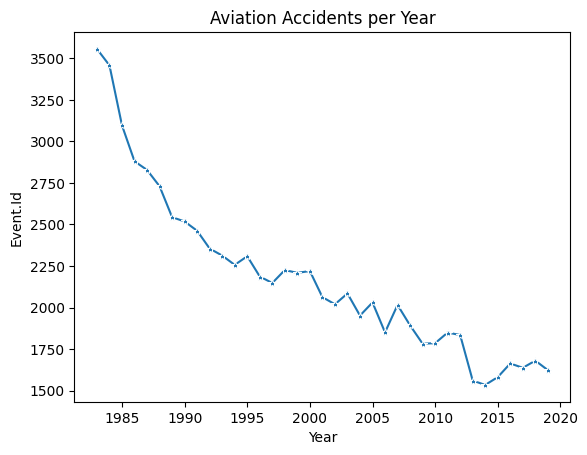

In [33]:
# Create the line plot
sns.lineplot(x='Year', y="Event.Id", data=Accidents, marker='*')
plt.title('Aviation Accidents per Year')
plt.xlabel('Year')

**Inference**
1. We can see that number of accodents per year gradually descreasing from1982 to 2020, with peaks and valleys.
2. The Decreasing trends suggests advancements in aircraft technology, maintainance, pilot training and safety

Aviation accidents per month

Text(0, 0.5, 'Number of Accidents')

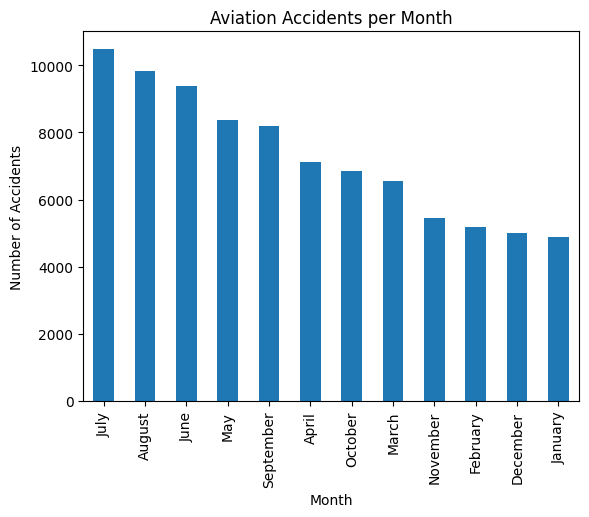

In [34]:
# Extracting month name
Aviation['Month.Abbr'] = Aviation['Event.Date'].dt.month_name()

Aviation['Month.Abbr'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Aviation Accidents per Month')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')

**Inference**

1. We can see that maximun number of accidents occur in the moth of July, August, June and May where as least accidents in the month of February, December and January
2. More accidents occur during summer months, likely due to increased travel and challenging weather

Aviation Accidents per day

Text(0, 0.5, 'Number of Accidents')

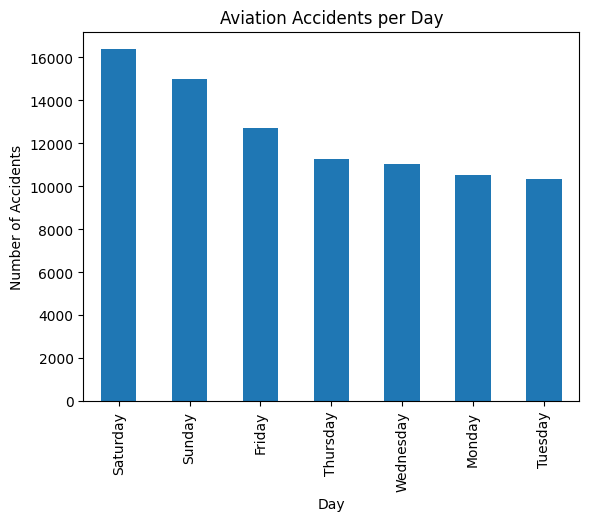

In [35]:
# Extracting day name
Aviation['week'] = Aviation['Event.Date'].dt.day_name()

Aviation['week'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Aviation Accidents per Day')
plt.xlabel('Day')
plt.ylabel('Number of Accidents')

**Inference**
1. Maximum accidents happend during Saturday and Sunday
2. Increased in accidents during the weekends


Accidents per Aviation Phase of Flights

Text(0, 0.5, 'Number of Accidents')

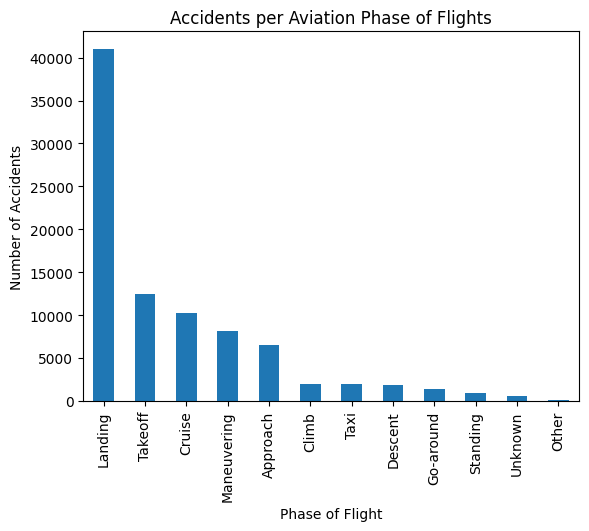

In [36]:
Aviation['Broad.phase.of.flight'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Accidents per Aviation Phase of Flights')
plt.xlabel('Phase of Flight')
plt.ylabel('Number of Accidents')

Inference
1. We can see that the maximum number of accidents occurs during the landing phase and as well as takeoff

Damage type and Weather conditions

In [37]:
Weather_damage = pd.DataFrame(Aviation['Weather.Condition'].groupby(Aviation['Aircraft.damage']).value_counts(normalize=True)*100)

In [38]:
Weather_damage

proportion
Aircraft.damage Weather.Condition            
Destroyed       VMC                 79.090171
                IMC                 18.017872
                UNK                  2.507447
                Unk                  0.384511
Minor           VMC                 90.448625
                IMC                  6.041968
                UNK                  2.496382
                Unk                  1.013025
Substantial     VMC                 95.568690
                IMC                  3.712965
                UNK                  0.491021
                Unk                  0.227324
Unknown         VMC                 94.117647
                Unk                  5.882353

array([<Axes: ylabel='proportion'>], dtype=object)

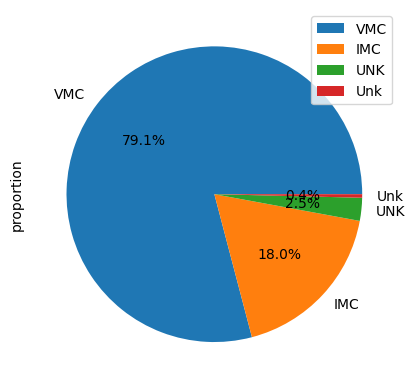

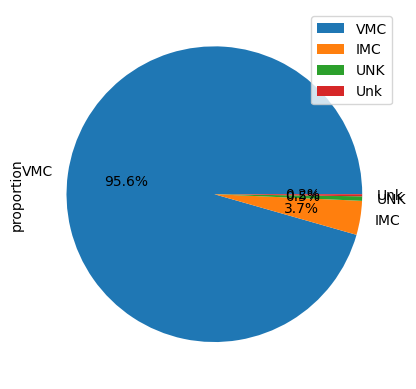

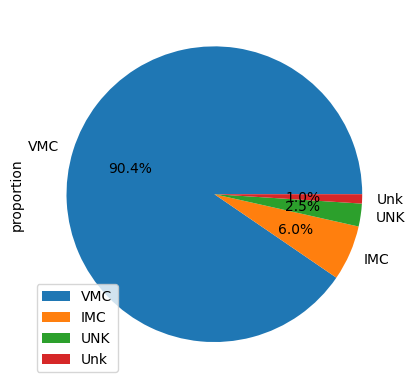

In [39]:
Weather_damage.loc['Destroyed'].plot(kind='pie',subplots=True,autopct='%1.1f%%')
Weather_damage.loc['Substantial'].plot(kind='pie',subplots=True,autopct='%1.1f%%')
Weather_damage.loc['Minor'].plot(kind='pie',subplots=True,autopct='%1.1f%%')


**Inference**
1. 79.1% of Aircraft which have been distroyed in the accidents where in VMC (Visual metrological condition) this indicates a region with predominantly clear weather
2. 95.6% of Aircraft which have been suffered with Substantally in the accidents where in VMC (Visual metrological condition) this indicates a region with predominantly clear weather
3. 90.4% aircraft has been suffered minor destruction

Damage Sustained

In [40]:
Damage = pd.DataFrame()
Damage['Damage_sustained']=(Aviation['Aircraft.damage'].value_counts(normalize=True)*100).index
Damage['Values']=(Aviation['Aircraft.damage'].value_counts(normalize=True)*100).values

In [41]:
Damage

,Damage_sustained,Values
0,Substantial,75.599780
1,Destroyed,21.155565
2,Minor,3.166747
3,Unknown,0.077908


Injuries over the year

In [42]:
Aviation[Aviation['Investigation.Type']=='Incident']

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,Aircraft.Category,Registration.Number,Make,Model,Amateur.Built,Engine.Type,FAR.Description,Schedule,Purpose.of.flight,Air.carrier,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Year,Month.Abbr,week
23,20020917X02333,Incident,LAX82IA034,1982-01-03,"VAN NUYS, CA",United States,332739N,0112457W,VNY,VAN NUYS,Incident,Minor,Airplane,N5018P,Piper,PA-24-180,No,Reciprocating,Part 91: General Aviation,NSCH,Personal,Pilot,VMC,Approach,Probable Cause,03-01-1983,1.0,0.0,0.0,0.0,1.0,1982,January,Sunday
40,20020917X01764,Incident,ATL82IA029,1982-01-05,"PENSACOLA, FL",United States,332739N,0112457W,NONE,Private,Incident,Minor,Airplane,N5782N,Rockwell,114,No,Reciprocating,Part 91: General Aviation,NSCH,Business,Pilot,VMC,Cruise,Probable Cause,05-01-1983,1.0,0.0,0.0,0.0,1.0,1982,January,Tuesday
79,20020917X01897,Incident,CHI82IA026,1982-01-12,"CHICAGO, IL",United States,332739N,0112457W,ORD,CHICAGO O'HARE INTER'L,Incident,Substantial,Airplane,N31031,Lockheed,L-1011,No,Turbo Fan,Part 121: Air Carrier,SCHD,Unknown,Trans World Airlines,UNK,Cruise,Probable Cause,12-01-1983,3.0,0.0,0.0,0.0,149.0,1982,January,Tuesday
80,20020917X01765,Incident,ATL82IA034,1982-01-12,"CLARKSBURG, WV",United States,332739N,0112457W,CKB,BENEDUM,Incident,Minor,Airplane,N615KC,Embraer,EMB-110P1,No,Turbo Prop,Part 135: Air Taxi & Commuter,SCHD,Unknown,Aeromech Incorporated,VMC,Taxi,Probable Cause,12-01-1983,2.0,0.0,0.0,0.0,2.0,1982,January,Tuesday
119,20020917X01766,Incident,ATL82IA038,1982-01-19,"WASHINGTON, DC",United States,332739N,0112457W,IAD,Private,Incident,Minor,Airplane,N9240N,De Havilland,DHC-6-300,No,Turbo Prop,Part 91: General Aviation,NSCH,Ferry,Pilot,IMC,Descent,Probable Cause,19-01-1983,2.0,0.0,0.0,0.0,1.0,1982,January,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87207,20211221104430,Incident,ENG22WA005,2021-11-22,"Owerri, Nigeria",Nigeria,332739N,0112457W,NONE,Private,Non-Fatal,Substantial,Airplane,5N-BUQ,BOEING,737,N,Reciprocating,NUSC,NSCH,Personal,Air Peace Limited,VMC,Landing,Probable Cause,25-09-2020,2.0,0.0,0.0,0.0,0.0,2021,November,Monday
87215,20211129104327,Incident,DCA22WA035,2021-11-25,"Bogata, Colombia",Colombia,004426N,0074849W,BOG,El Dorado International Airpor,Non-Fatal,Minor,Airplane,N1604R,BOEING,767-332,N,Reciprocating,121,NSCH,Personal,DELTA AIR LINES INC,VMC,Landing,Probable Cause,25-09-2020,2.0,0.0,0.0,0.0,206.0,2021,November,Thursday
87229,20211207104357,Incident,DCA22WA039,2021-12-01,"Kuusamo, Finland",Finland,332739N,0112457W,NONE,Private,Non-Fatal,Substantial,Airplane,G-JZHL,BOEING,737,N,Reciprocating,NUSC,NSCH,Personal,Pilot,VMC,Landing,Probable Cause,25-09-2020,1.0,0.0,0.0,0.0,0.0,2021,December,Wednesday
87266,20211220104425,Incident,DCA22WA051,2021-12-13,"West Sumatera, Indonesia",Indonesia,332739N,0112457W,NONE,Private,Non-Fatal,Substantial,Airplane,PK-LQR,BOEING,737,N,Reciprocating,129,SCHD,Personal,PT. Lion Mentari Airlines,VMC,Landing,Probable Cause,25-09-2020,1.0,0.0,0.0,0.0,203.0,2021,December,Monday


In [43]:
Incident=Aviation[Aviation['Investigation.Type']=='Incident']
Incident_injuries = Incident.groupby('Year')[['Total.Fatal.Injuries','Total.Serious.Injuries','Total.Minor.Injuries']].sum().reset_index()

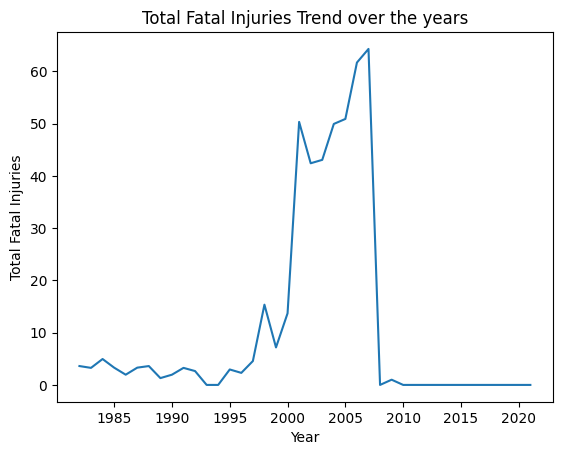

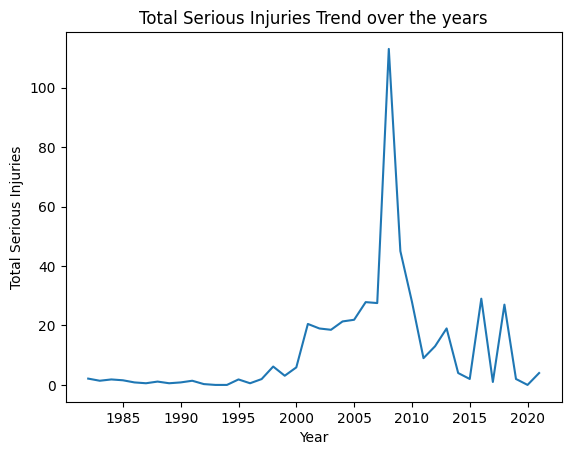

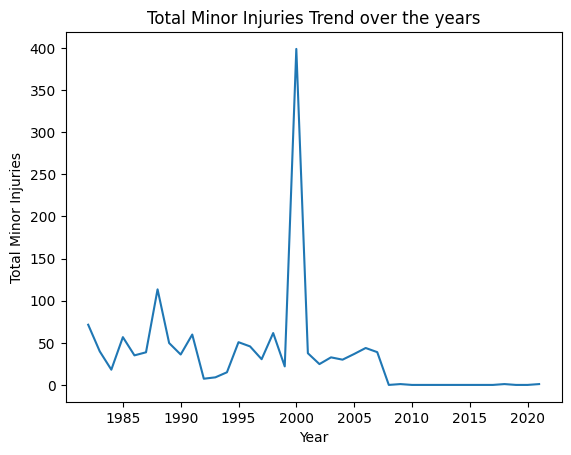

In [44]:
for i in ['Total.Fatal.Injuries','Total.Serious.Injuries','Total.Minor.Injuries']:
  sns.lineplot(x='Year',y=i, data=Incident_injuries, legend=True)
  plt.title('{} Trend over the years'.format(' '.join(i.split('.'))))
  plt.xlabel('Year')
  plt.ylabel(' '.join(i.split('.')))
  plt.show()

1. A spike in total fetal injuries have been recorded in between year of 2000 to 2008
2. A spike in total serious injuries have been recorded in the between 2007 to 2010
3. A spike in total minor injuries have been recorded in between the year 1998 to 2002

Based on Engine Type

<Axes: xlabel='Engine.Type', ylabel='Total.Fatal.Injuries'>

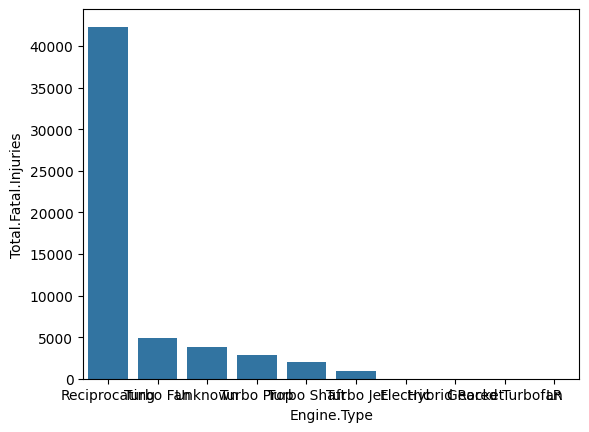

In [45]:
sns.barplot(x='Engine.Type', y='Total.Fatal.Injuries', data=Aviation.groupby('Engine.Type')['Total.Fatal.Injuries'].sum().reset_index().sort_values(by=['Total.Fatal.Injuries'],ascending=False))

Data Transformation Technique for Categorical to Numerical Values

In [46]:
Drop=['Publication.Date','Report.Status','FAR.Description','Accident.Number','Registration.Number','Model','Latitude'	,'Longitude']

In [47]:
Aviation.drop(columns=Drop,axis=1, inplace=True)

In [48]:
Aviation.head(2)

,Event.Id,Investigation.Type,Event.Date,Location,Country,Airport.Code,Airport.Name,Injury.Severity,Aircraft.damage,Aircraft.Category,Make,Amateur.Built,Engine.Type,Schedule,Purpose.of.flight,Air.carrier,Weather.Condition,Broad.phase.of.flight,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Year,Month.Abbr,week
0,20001218X45444,Accident,1948-10-24,"MOOSE CREEK, ID",United States,NONE,Private,Fatal(2),Destroyed,Airplane,Stinson,No,Reciprocating,NSCH,Personal,Pilot,UNK,Cruise,1.0,2.0,0.0,0.0,0.0,1948,October,Sunday
1,20001218X45447,Accident,1962-07-19,"BRIDGEPORT, CA",United States,NONE,Private,Fatal(4),Destroyed,Airplane,Piper,No,Reciprocating,NSCH,Personal,Pilot,UNK,Unknown,1.0,4.0,0.0,0.0,0.0,1962,July,Thursday


In [49]:
for i in Aviation:
  if Aviation[i].dtype == 'object':
    Aviation[i] = Aviation[i].str.title()
    if 'Unknown' in Aviation[i].values:
      Aviation[i].replace({'Unknown':Aviation[i].mode()[0]},inplace=True)

Encoding for Target Variable

In [50]:
Aviation['Aircraft.damage'].unique()

array(['Destroyed', 'Substantial', 'Minor'], dtype=object)

In [51]:
Aviation['Aircraft.damage'].replace({'Minor':0,'Substantial':1,'Destroyed':2},inplace=True)

In [52]:
Categorical_data = Aviation.select_dtypes('object').columns.to_list()
Categorical_data

['Event.Id',
 'Investigation.Type',
 'Location',
 'Country',
 'Airport.Code',
 'Airport.Name',
 'Injury.Severity',
 'Aircraft.Category',
 'Make',
 'Amateur.Built',
 'Engine.Type',
 'Schedule',
 'Purpose.of.flight',
 'Air.carrier',
 'Weather.Condition',
 'Broad.phase.of.flight',
 'Month.Abbr',
 'week']

Label Encoding

In [53]:
LE = LabelEncoder()
Aviation[Categorical_data] = Aviation[Categorical_data].apply(LE.fit_transform)

Check for outliers

In [54]:
Discrete_columns=['Number.of.Engines','Total.Fatal.Injuries','Total.Serious.Injuries','Total.Minor.Injuries','Total.Uninjured']

In [55]:
# Now will perform descriptive stats for the above discreate columns
Aviation[Discrete_columns].describe()

,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
count,87282.000000,87282.000000,87282.000000,87282.000000,87282.000000
mean,1.137440,0.652772,0.280921,0.360814,5.311847
std,0.433648,5.148114,1.441544,2.097714,26.937712
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.652772,0.280921,0.360814,2.000000
max,8.000000,349.000000,161.000000,380.000000,699.000000


In [56]:
# Define the Percentile threshold for deleting outliers

percentile_threshold=95
for column in Discrete_columns:
  threshold = np.percentile(Aviation[column], percentile_threshold)
  Aviation = Aviation[Aviation[column]<=threshold]

In [57]:
Aviation[Discrete_columns].describe()

,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
count,74651.000000,74651.000000,74651.000000,74651.000000,74651.000000
mean,1.080575,0.329366,0.149777,0.258952,1.425432
std,0.318830,0.566906,0.312286,0.496265,1.473954
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.652772,0.280921,0.360814,2.000000
max,2.000000,2.000000,1.000000,2.000000,5.311847


Simple Random Sampling

In [58]:
# Create a VIF
New_Aviation = Aviation.drop(['Event.Date','Aircraft.damage'], axis=1)

# Claculate the VIF for each predictor variable

VIF_Scores = pd.DataFrame()
VIF_Scores['Feature'] = New_Aviation.columns
VIF_Scores['VIF'] = [variance_inflation_factor(New_Aviation.values, i) for i in range(New_Aviation.shape[1])]
VIF_Scores

,Feature,VIF
0,Event.Id,5.800781
1,Investigation.Type,1.157809
2,Location,4.487369
3,Country,59.053194
4,Airport.Code,9.745639
5,Airport.Name,8.709293
6,Injury.Severity,19.082714
7,Aircraft.Category,1.198063
8,Make,2.866209
9,Amateur.Built,3.661084


In [59]:
# Set a Threshold for VIF
threshold =15

# Select Features with VIF below the threshold value
Selected_Features = VIF_Scores[VIF_Scores['VIF']<threshold]['Feature'].values
Selected_Features

array(['Event.Id', 'Investigation.Type', 'Location', 'Airport.Code',
       'Airport.Name', 'Aircraft.Category', 'Make', 'Amateur.Built',
       'Schedule', 'Broad.phase.of.flight', 'Number.of.Engines',
       'Total.Fatal.Injuries', 'Total.Serious.Injuries',
       'Total.Minor.Injuries', 'Total.Uninjured', 'Month.Abbr', 'week'],
      dtype=object)

In [60]:
# Create a new DataFrame with the selected features
New_Aviation_X = New_Aviation[Selected_Features]

In [61]:
New_Aviation_X

,Event.Id,Investigation.Type,Location,Airport.Code,Airport.Name,Aircraft.Category,Make,Amateur.Built,Schedule,Broad.phase.of.flight,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Month.Abbr,week
0,45208,0,12645,7727,15407,0,6421,1,0,2,1.0,2.0,0.0,0.0,0.0,10,3
3,45212,0,5997,7727,15407,0,5642,1,0,2,1.0,2.0,0.0,0.0,0.0,6,3
7,49012,0,15796,7727,1757,0,1226,1,0,9,1.0,0.0,0.0,0.0,2.0,4,0
8,49011,0,5416,7553,8058,0,1226,1,0,5,2.0,0.0,0.0,0.0,2.0,4,0
10,49009,0,8415,7727,15407,0,5153,1,0,0,1.0,0.0,0.0,0.0,1.0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87276,86361,1,13653,7727,15407,0,5153,0,0,5,1.0,0.0,0.0,0.0,0.0,2,5
87277,86364,0,1026,7727,15407,0,1321,0,0,5,1.0,1.0,0.0,0.0,0.0,2,5
87278,86368,0,969,7727,15407,0,1226,0,0,5,1.0,0.0,0.0,1.0,0.0,2,6
87279,86366,0,7934,7727,15407,0,1226,0,0,5,1.0,2.0,0.0,0.0,0.0,2,3


In [62]:
# Concatinate the New_Aviation_X and Aircraft.Damage

Aviation = pd.concat([New_Aviation_X, Aviation['Aircraft.damage']], axis=1)

In [63]:
Aviation

,Event.Id,Investigation.Type,Location,Airport.Code,Airport.Name,Aircraft.Category,Make,Amateur.Built,Schedule,Broad.phase.of.flight,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Month.Abbr,week,Aircraft.damage
0,45208,0,12645,7727,15407,0,6421,1,0,2,1.0,2.0,0.0,0.0,0.0,10,3,2
3,45212,0,5997,7727,15407,0,5642,1,0,2,1.0,2.0,0.0,0.0,0.0,6,3,2
7,49012,0,15796,7727,1757,0,1226,1,0,9,1.0,0.0,0.0,0.0,2.0,4,0,1
8,49011,0,5416,7553,8058,0,1226,1,0,5,2.0,0.0,0.0,0.0,2.0,4,0,1
10,49009,0,8415,7727,15407,0,5153,1,0,0,1.0,0.0,0.0,0.0,1.0,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87276,86361,1,13653,7727,15407,0,5153,0,0,5,1.0,0.0,0.0,0.0,0.0,2,5,1
87277,86364,0,1026,7727,15407,0,1321,0,0,5,1.0,1.0,0.0,0.0,0.0,2,5,2
87278,86368,0,969,7727,15407,0,1226,0,0,5,1.0,0.0,0.0,1.0,0.0,2,6,1
87279,86366,0,7934,7727,15407,0,1226,0,0,5,1.0,2.0,0.0,0.0,0.0,2,3,1


Now will convert multiclass classification problem statement to binary class

In [64]:
Aviation['Aircraft.damage'].replace({1:0, 2:1}, inplace=True)

Train Test Split

In [65]:
Train, Test= train_test_split(Aviation, test_size=0.3, random_state=42)
Train.shape, Test.shape

((52255, 18), (22396, 18))

In [66]:
Train_X= Train.drop('Aircraft.damage', axis=1)
Train_Y= Train['Aircraft.damage']

In [67]:
Test_X= Test.drop('Aircraft.damage', axis=1)
Test_Y= Test['Aircraft.damage']

In [68]:
Train_X.shape, Test_X.shape

((52255, 17), (22396, 17))

In [69]:
Train_Y.shape, Train_Y.shape

((52255,), (52255,))

In [70]:
Train_Y.value_counts(normalize=True)*100

,proportion
Aircraft.damage,
0,81.347239
1,18.652761


Logistic Model

In [71]:
LR = LogisticRegression()
LR.fit(Train_X, Train_Y)
# Prediction
Y_LR= LR.predict(Test_X)

In [72]:
Accuracy_LR=accuracy_score(Test_Y, Y_LR)*100
Accuracy_LR

83.58635470619753

In [73]:
Precision_LR=precision_score(Test_Y, Y_LR)*100
Precision_LR

69.47565543071161

In [74]:
Recall_LR=recall_score(Test_Y, Y_LR)*100
Recall_LR

18.132942326490713

In [75]:
F1_score_LR=f1_score(Test_Y, Y_LR)*100
F1_score_LR

28.759689922480618

In [76]:
confusion_matrix_LR=confusion_matrix(Test_Y, Y_LR)*100
confusion_matrix_LR

array([[1797800,   32600],
       [ 335000,   74200]])

Random Undersampling

In [77]:
undersampler = RandomUnderSampler(random_state=42)
Train_X, Train_Y = undersampler.fit_resample(Train_X, Train_Y)
Test_X, Test_Y = undersampler.fit_resample(Test_X, Test_Y)

In [78]:
Train_X.shape, Train_Y.shape, Test_X.shape, Test_Y.shape

((19494, 17), (19494,), (8184, 17), (8184,))

In [79]:
Test_Y.value_counts()

,count
Aircraft.damage,
0,4092
1,4092


In [80]:
# After Performing Undersampling
LR = LogisticRegression()
LR.fit(Train_X, Train_Y)

# Prediction
Y_LR= LR.predict(Test_X)

Accuracy_LR=accuracy_score(Test_Y, Y_LR)*100
print('Accuracy',Accuracy_LR)
Precision_LR=precision_score(Test_Y, Y_LR)*100
print('Precision_LR',Precision_LR)
Recall_LR=recall_score(Test_Y, Y_LR)*100
print('Recall_LR',Recall_LR)
F1_score_LR=f1_score(Test_Y, Y_LR)*100
print('F1_score_LR',F1_score_LR)
confusion_matrix_LR=confusion_matrix(Test_Y, Y_LR)*100
print('confusion_matrix_LR',confusion_matrix_LR)

Accuracy 71.21212121212122
Precision_LR 71.72172172172172
Recall_LR 70.03910068426198
F1_score_LR 70.8704253214639
confusion_matrix_LR [[296200 113000]
 [122600 286600]]


Decision Tree

In [81]:
# After Performing Undersampling
DT = DecisionTreeClassifier()
DT.fit(Train_X, Train_Y)

# Prediction
Y_DT= DT.predict(Test_X)

Accuracy_DT=accuracy_score(Test_Y, Y_DT)*100
print('Accuracy',Accuracy_DT)
Precision_DT=precision_score(Test_Y, Y_DT)*100
print('Precision_DT',Precision_DT)
Recall_DT=recall_score(Test_Y, Y_DT)*100
print('Recall_DT',Recall_DT)
F1_score_DT=f1_score(Test_Y, Y_DT)*100
print('F1_score_DT',F1_score_DT)
confusion_matrix_DT=confusion_matrix(Test_Y, Y_DT)*100
print('confusion_matrix_DT',confusion_matrix_DT)

Accuracy 75.0366568914956
Precision_DT 74.69269703543023
Recall_DT 75.73313782991202
F1_score_DT 75.20931925737167
confusion_matrix_DT [[304200 105000]
 [ 99300 309900]]


In [82]:
Parameters={
    'criterion':['gini','entropy'],
    'max_depth':[5,10],
    'min_samples_split':[5,10],
}

grid_search = GridSearchCV(estimator=DT, param_grid=Parameters, cv=5)
grid_search.fit(Train_X, Train_Y)
params = grid_search.best_params_
params

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}

In [83]:
grid_search.best_score_*100

np.float64(82.04062269587749)

In [84]:
DT = DecisionTreeClassifier(**params)
DT.fit(Train_X, Train_Y)

# Prediction
Y_DT= DT.predict(Test_X)

Accuracy_DT=accuracy_score(Test_Y, Y_DT)*100
print('Accuracy',Accuracy_DT)

Accuracy 82.42913000977518


In [85]:
threshold = 0.33
DT.predict_proba(Test_X)[:,1] >= threshold

array([False, False,  True, ..., False,  True,  True])

In [86]:
# Accuracy of the model
accuracy_score(Test_Y, DT.predict(Test_X))

0.8242913000977518

In [87]:
Accuracy_DT=accuracy_score(Test_Y, Y_DT)*100
print('Accuracy',Accuracy_DT)
Precision_DT=precision_score(Test_Y, Y_DT)*100
print('Precision_DT',Precision_DT)
Recall_DT=recall_score(Test_Y, Y_DT)*100
print('Recall_DT',Recall_DT)
F1_score_DT=f1_score(Test_Y, Y_DT)*100
print('F1_score_DT',F1_score_DT)

Accuracy 82.42913000977518
Precision_DT 87.63471355643789
Recall_DT 75.51319648093842
F1_score_DT 81.12365450249409


Random Forest

In [88]:
RF = RandomForestClassifier()
RF.fit(Train_X, Train_Y)

# Prediction
Y_RF= RF.predict(Test_X)

In [89]:
Accuracy_RF = accuracy_score(Test_Y, Y_RF)*100
print('Accuracy',Accuracy_RF)

Accuracy 82.31915933528838


In [90]:
Precision_RF = precision_score(Test_Y, Y_RF)*100
print('Precision_RF',Precision_RF)

Precision_RF 83.97123041356281


In [91]:
Recall_RF = recall_score(Test_Y, Y_RF)*100
print('Recall_RF',Recall_RF)

Recall_RF 79.88758553274681


In [92]:
F1_score_RF = f1_score(Test_Y, Y_RF)*100
print('F1_score_RF',F1_score_RF)

F1_score_RF 81.87852222917971


In [93]:
Parameters={
    'n_estimators':[100,200],
    'max_depth':[None, 5,10],
    'min_samples_split':[5,10],
}

In [94]:
grid_search = GridSearchCV(estimator=RF, param_grid=Parameters, cv=5)
grid_search.fit(Train_X, Train_Y)
params = grid_search.best_params_
params

{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}

In [95]:
RF = RandomForestClassifier(**params)
RF.fit(Train_X, Train_Y)

# Prediction
Y_RF= RF.predict(Test_X)

Accuracy_RF=accuracy_score(Test_Y, Y_RF)*100
print('Accuracy',Accuracy_RF)

Accuracy 82.50244379276637


In [96]:
Precision_RF = precision_score(Test_Y, Y_RF)*100
print('Precision_RF',Precision_RF)

Precision_RF 84.59937565036421


In [97]:
Recall_RF = recall_score(Test_Y, Y_RF)*100
print('Recall_RF',Recall_RF)

Recall_RF 79.47214076246334


In [98]:
F1_score_RF = f1_score(Test_Y, Y_RF)*100
print('F1_score_RF',F1_score_RF)

F1_score_RF 81.95564516129032


# **With the comparing to the Decision Tree and Logistic Regression models, Random Forest Classifier has the best Accuracy**

# Global Feature Importance using SHAP

<Figure size 640x480 with 0 Axes>

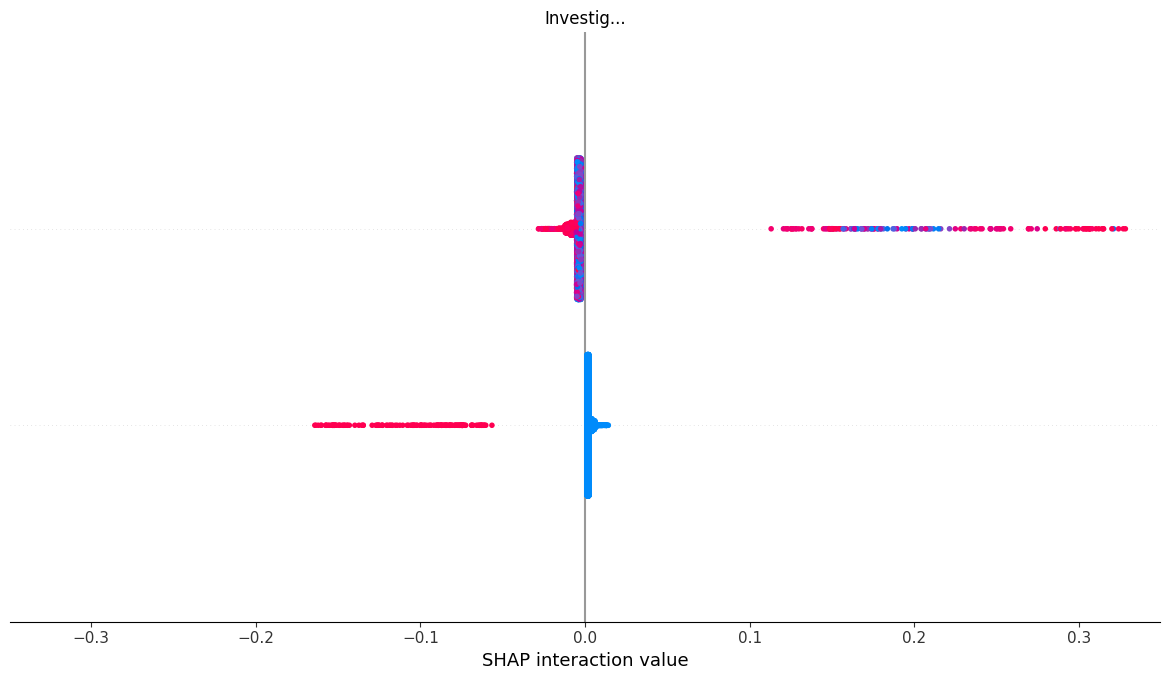

In [99]:
import shap

explainer = shap.TreeExplainer(RF)
shap_values = explainer.shap_values(Test_X)

# Ensure Test_X is a DataFrame
if not isinstance(Test_X, pd.DataFrame):
    Test_X = pd.DataFrame(Test_X, columns=Train_X.columns)

# Handle binary classification (list of arrays)
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[1], Test_X, plot_type="bar")
else:
    shap.summary_plot(shap_values, Test_X, plot_type="bar")
